# Explore here

Paso 1. Lectura del conjunto de datos

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
data = pd.read_csv(url) 

In [221]:
data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [222]:
data['date'] = pd.to_datetime(data['date']).dt.normalize()
# data['date'] = data["date"].dt.strftime('%Y-%m-%d') # con esto daba error
# data['date'] = pd.to_datetime(data['date'])
data = data.set_index("date")
ts = data["sales"]  # time series

In [223]:
data

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633
...,...
2023-08-30,989.600354
2023-08-31,994.987326
2023-09-01,995.814415


A continuación visualizaremos la serie temporal para llevar a cabo un análisis visual de la misma:

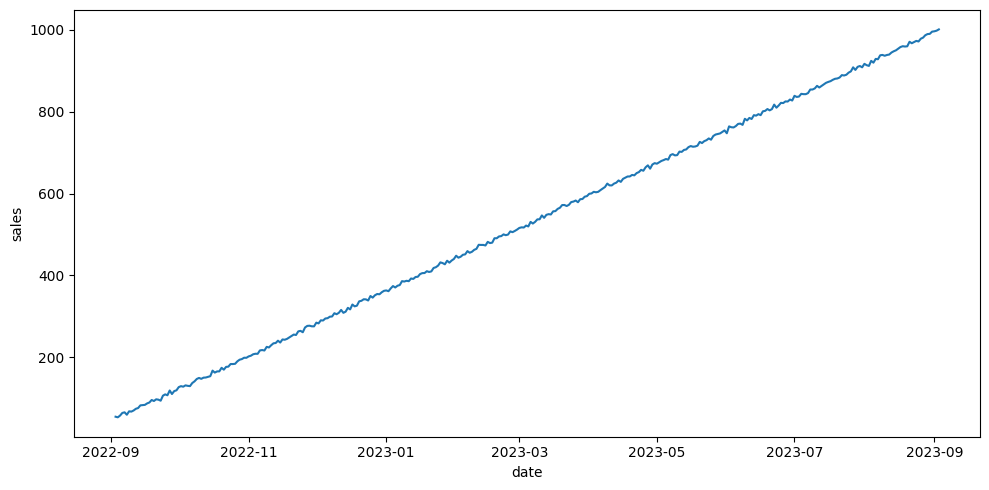

In [224]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

#### Descomposición de la serie
La descomposición de una serie temporal es un proceso estadístico que separa de una serie de tiempo en varios elementos diferenciados. Cada uno de estos componentes representa una parte de la estructura subyacente de la serie temporal. La descomposición de una serie de tiempo puede ser muy útil para entender mejor los datos y tomar decisiones informadas al construir modelos de pronóstico.

In [225]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period = 24) # o nada y que la función lo detecte
decomposition

#### Análisis de la tendencia

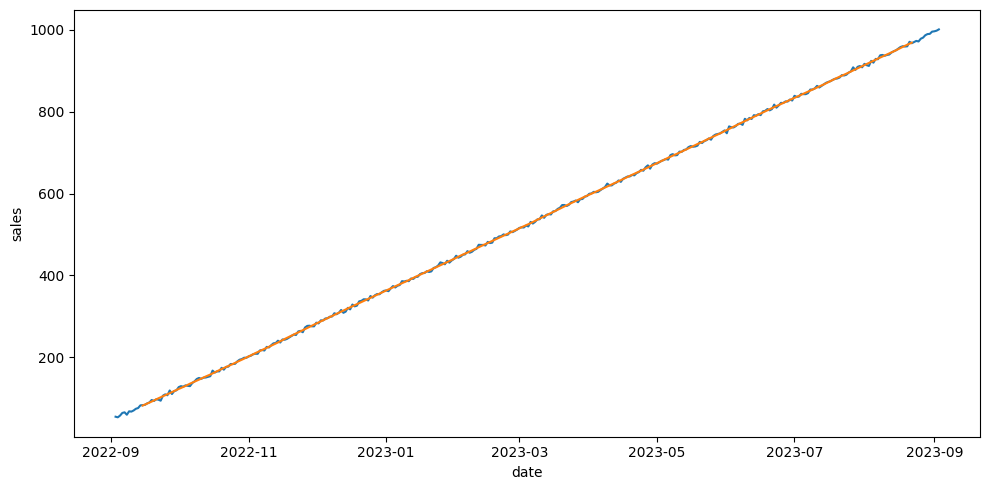

In [226]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

#### Análisis de la estacionalidad

Patrones repetitivos en los datos.

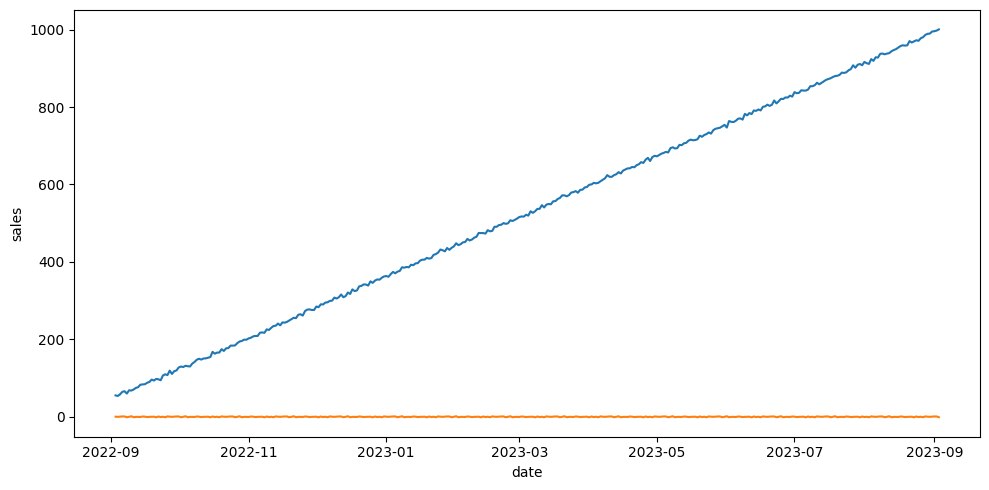

In [227]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Para evaluar la estacionalidad de la serie temporal podemos aplicar la llamada Prueba de Dickey-Fuller (Dickey-Fuller test), que es un contraste de hipótesis en el que la hipótesis nula es que la serie es estacionaria, y la alternativa, que es no estacionaria

In [228]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

# p-value < 0.05 es la hipótesis nula. Se rechaza la hipótesis nula y por tanto nos quedamos con la alternativa.
# Hipótesis nula: Es estacionaria.
# Hipótesis alternativa: No es estacionaria.
test_stationarity(ts)

Dickey-Fuller test results:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Aquí podemos ver que el p-value es mayor a 0.05, esto significa que nuestra hipótesis nula será rechazada y tomaremos esta serie como no estacionaria.

#### Análisis de la variabilidad
Cómo fluctúan los datos una vez se ha estudiado la tendencia y la estacionalidad

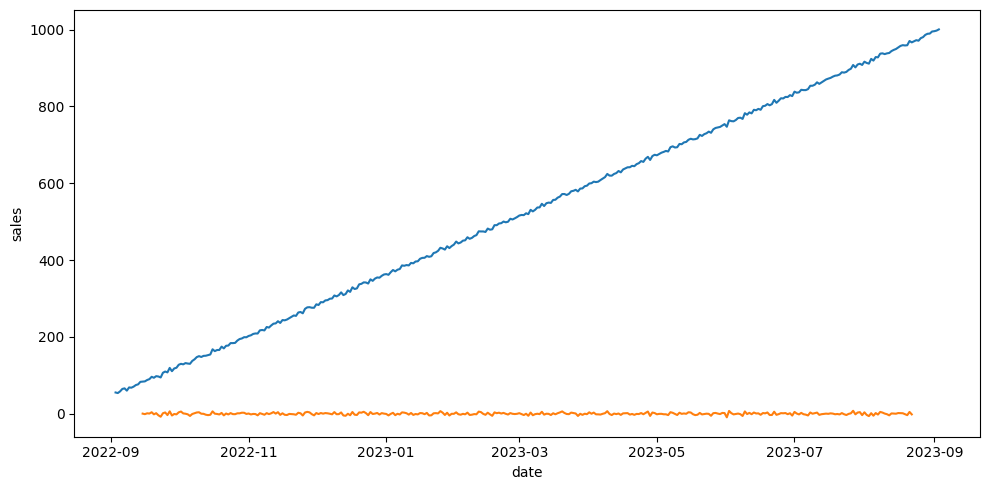

In [229]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Se confirma en parte lo observado, ya que la carga de residuos se hace más notable al inicio y al final del periodo estudiado.

#### Análisis de la autocorrelación
La autocorrelación es la correlación de una serie de tiempo con una copia retrasada de sí misma. Este gráfico nos ayuda a ver si los valores en la serie de tiempo están correlacionados con los valores anteriores.

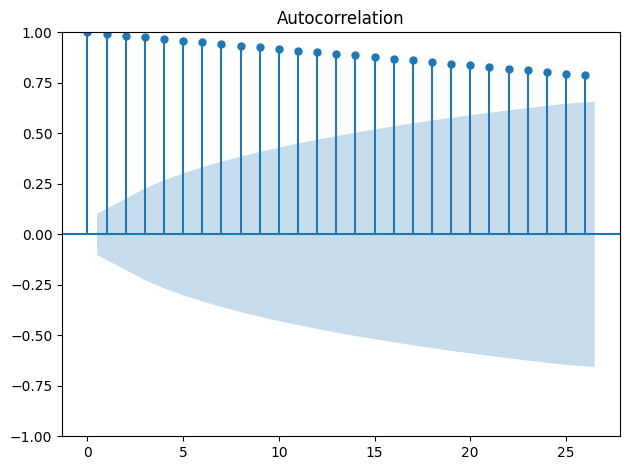

In [230]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts)

plt.tight_layout()

plt.show()

Se aprecia una alta correlación entre los puntos y sus copias retrasadas, que disminuye a lo largo del tiempo.

### Paso 3: Entrenamiento del modelo

##### ¿Qué es una serie estacionaria?
Una serie de tiempo es estacionaria si sus propiedades estadísticas (como media, varianza y autocorrelación) no cambian con el tiempo. Es decir, no tiene tendencias, ni estacionalidades marcadas, ni cambios en la varianza.

Los modelos como ARIMA suponen que la serie es estacionaria. Si no lo es, los resultados pueden ser poco confiables.

Un modelo ARIMA (p,d,q) consta de tres hiperparámetros:

p: El orden del componente autorregresivo (AR).
d: El grado de diferenciación necesario para hacer la serie de tiempo estacionaria.
q: El orden del componente de media móvil (MA).

 Para optimizar al máximo sus resultados, debemos transformar la serie en estacionaria, y como en el caso de esta serie no lo es, debemos transformarla

***

diff(): Calcula la diferencia entre valores consecutivos de una serie de tiempo ts. Es decir, transforma la serie original en una nueva donde cada valor es la diferencia entre el valor actual y el anterior:
        diff(t) = ts(t) - ts(t-1)
 
Esto se usa comúnmente para hacer estacionaria una serie, especialmente si tiene una tendencia.

In [ ]:

ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Dickey-Fuller test results:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

✅ Resumen:

ts.diff().dropna() se usa para quitar tendencia y convertir la serie en estacionaria.

Es un paso previo necesario para aplicar ARIMA y otros modelos similares.

Se puede verificar si quedó estacionaria con una prueba como Dickey-Fuller (ADF).

Ahora la serie si que lo es, y podemos aplicar el método ARIMA automático:

Como anteriormente le hemos aplicado el diff(), ya ha hecho un diferenciamiento 1 vez, por lo que si le aplicara el auto_arima otra vez lo estaría haciendo dos veces. Es por eso que especifico el d=0. La otra opción sería dejar que auto_arima haga el diferenciamiento de forma automática. Pero lo que no se debe de hacer para evitar el diferenciamiento 2 veces es aplicar el diff() y usar el auto_arima, porque ahí el modelo cree que está viendo la serie original, y puede elegir mal el d.

In [238]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 24, d=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=1846.864, Time=3.12 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2096.542, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=1972.915, Time=0.55 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1841.580, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=2209.657, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=1839.587, Time=0.14 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=1841.583, Time=1.82 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=1843.509, Time=1.93 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=1839.553, Time=0.35 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=1841.556, Time=2.34 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=1841.552, Time=3.02 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=1843.462, Time=2.97 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=1970.972, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=1841.533, Time=0.60 sec
 ARIMA(1,0,2)(0,0,0

***
En este caso al usar auto_arima usamos el diff para quitar tendencia y convertir la serie en estacionaria, pero por la propia función sería algo opcional. Pero como se considera que es importante, ya que es necesario aplicar cuando es la función ARIMA y en otros modelos, se mantiene para tenerlo como referencia en el futuro.

 ¿Entonces para qué usar .diff().dropna() manualmente?

A veces prefieres preprocesar tú mismo la serie si sabes que es necesario (por control, por visualización, o para otros modelos).

Si ya sabes que la serie necesita una diferenciación de orden 1, podrías hacerlo manualmente para acelerar el proceso.

También puede ayudarte a visualizar si la serie queda estacionaria antes de modelar
***

 El modelo que devuelve esta función es totalmente usable, summary presenta la info estadística y su rendimiento:

In [239]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Thu, 10 Apr 2025   AIC                           1839.553
Time:                        13:46:57   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Paso 3: Predicción del modelo

Una vez se ha entrenado el modelo, se puede utilizar para predecir a futuro

In [246]:
forecast = model.predict(100)
forecast

2023-09-04    1.675366
2023-09-05    2.673520
2023-09-06    2.591621
2023-09-07    2.598341
2023-09-08    2.597789
                ...   
2023-12-08    2.597831
2023-12-09    2.597831
2023-12-10    2.597831
2023-12-11    2.597831
2023-12-12    2.597831
Freq: D, Length: 100, dtype: float64

In [247]:
forecast_real = forecast.cumsum() + ts.iloc[-1]

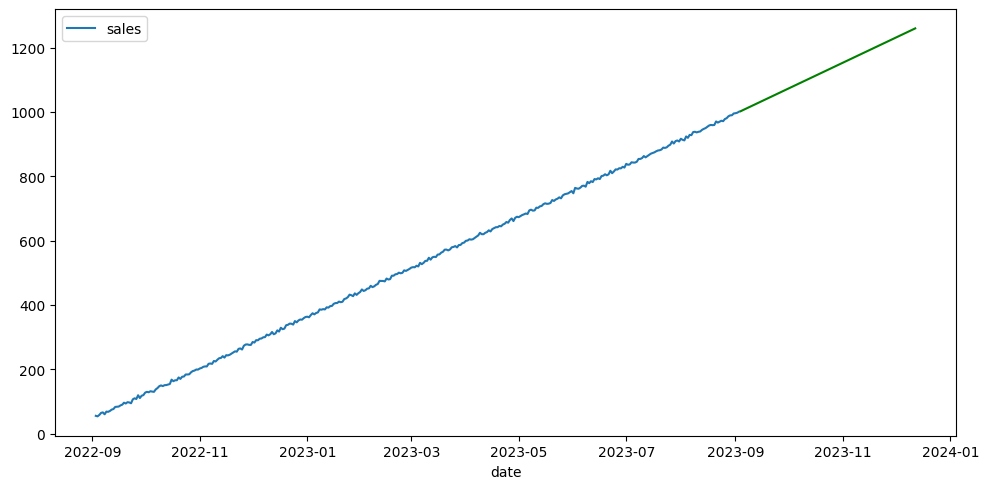

In [248]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = data)
#sns.lineplot(data = forecast, color = "green")
sns.lineplot(data = forecast_real, color="green")

plt.tight_layout()

plt.show()

Ahora nuestro modelo es capaz de realizar predicciones a futuro sobre nuestra serie estacionaria. 

Otra forma de representar los gráficos. Observamos que presenta mucho ruido y por tanto a la hora de predecir el modelo no tiene del todo claro que debe escoger y por tanto indica la media, de ahí que se vea una constante.

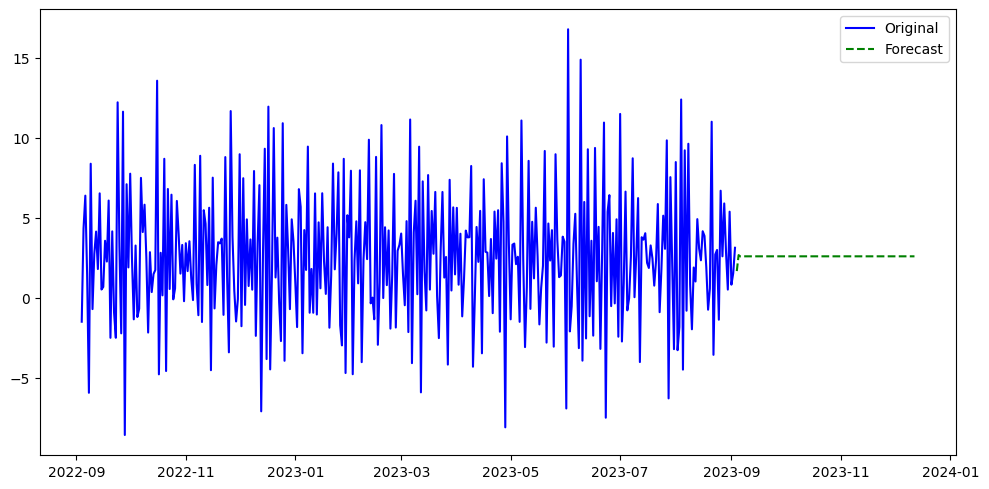

In [249]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize=(10, 5))

# Línea original
axis.plot(ts_stationary.index, ts_stationary.values, label="Original", color="blue")

# Forecast
axis.plot(forecast.index, forecast.values, label="Forecast", color="green", linestyle="--")

axis.legend()
plt.tight_layout()
plt.show()
